Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

Подготавливаем данные на основе EDA.

In [21]:
df = pd.read_excel('data/data.xlsx', index_col=0) 
target_vars = ['IC50, mM', 'CC50, mM', 'SI']
target_col = 'IC50, mM'

numeric_cols = df.select_dtypes(include=[np.number]).columns
feature_cols = [col for col in numeric_cols if col not in target_vars and col != df.columns[0]]

X = df[feature_cols]

ic50_values = df[target_col]
ic50_median = ic50_values.median()

y = (ic50_values > ic50_median).astype(int)

print(f"Медиана IC50: {ic50_median:.3f} mM")
print(f"Класс 0 (эффективные): {(y == 0).sum()} соединений")
print(f"Класс 1 (неэффективные): {(y == 1).sum()} соединений")
print(f"Баланс классов: {(y == 0).sum()/(y == 1).sum():.2f}")

X_clean = X.loc[:, X.std() > 0]
print(f"Удалено {X.shape[1] - X_clean.shape[1]} константных признаков")

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X_clean), columns=X_clean.columns)
print(f"Заполнены пропущенные значения")

corr_matrix = X_imputed.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = []
for column in upper_triangle.columns:
    if any(upper_triangle[column] > 0.95):
        to_drop.append(column)

X_final = X_imputed.drop(columns=to_drop)
print(f"Удалено {len(to_drop)} высококоррелированных признаков")
print(f"Финальные данные: {X_final.shape[1]} признаков\n")


Медиана IC50: 46.585 mM
Класс 0 (эффективные): 501 соединений
Класс 1 (неэффективные): 500 соединений
Баланс классов: 1.00
Удалено 18 константных признаков
Заполнены пропущенные значения
Удалено 33 высококоррелированных признаков
Финальные данные: 159 признаков



Разделим данные и отберем признаки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
selector = SelectKBest(score_func=f_classif, k=50)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X_train_scaled.columns[selector.get_support()]
print(f"Отобрано {len(selected_features)} лучших признаков\n")


Обучающая выборка: (800, 159)
Тестовая выборка: (201, 159)
Отобрано 50 лучших признаков



Определим модели для обучения

In [23]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}
param_grids = {
    'Logistic Regression': {'C': [0.1, 1.0, 10.0, 100.0]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'SVM': {'C': [0.1, 1.0, 10.0], 'gamma': ['scale', 'auto']}
}

Обучение моделей

In [24]:
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Обучение {name}...")
    
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=cv, 
                                 scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_selected, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train_selected, y_train)
    
    y_pred_test = best_model.predict(X_test_selected)
    
    if hasattr(best_model, 'predict_proba'):
        y_proba_test = best_model.predict_proba(X_test_selected)[:, 1]
    else:
        y_proba_test = best_model.decision_function(X_test_selected)
    
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_proba_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    cv_roc_auc = cross_val_score(best_model, X_train_selected, y_train, cv=cv, scoring='roc_auc')
    
    results[name] = {
        'model': best_model,
        'test_accuracy': test_accuracy,
        'test_roc_auc': test_roc_auc,
        'test_f1': test_f1,
        'cv_roc_auc': cv_roc_auc.mean(),
        'y_test': y_test,
        'y_pred': y_pred_test,
        'y_proba': y_proba_test
    }
    
    print(f"  Accuracy: {test_accuracy:.3f}, ROC-AUC: {test_roc_auc:.3f}, F1: {test_f1:.3f}")


Обучение Logistic Regression...
  Accuracy: 0.652, ROC-AUC: 0.739, F1: 0.649
Обучение Random Forest...
  Accuracy: 0.692, ROC-AUC: 0.768, F1: 0.689
Обучение SVM...
  Accuracy: 0.706, ROC-AUC: 0.766, F1: 0.703
Обучение Naive Bayes...
  Accuracy: 0.667, ROC-AUC: 0.707, F1: 0.667


Лучшая модель

In [25]:
results_df = pd.DataFrame({
    name: {
        'Test ROC-AUC': result['test_roc_auc'],
        'Test Accuracy': result['test_accuracy'],
        'Test F1': result['test_f1'],
        'CV ROC-AUC': result['cv_roc_auc']
    } for name, result in results.items()
}).T.sort_values('Test ROC-AUC', ascending=False)
best_model_name = results_df.index[0]
best_result = results[best_model_name]

print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"Test ROC-AUC: {best_result['test_roc_auc']:.3f}")
print(f"Test Accuracy: {best_result['test_accuracy']:.3f}")
print(f"Test F1: {best_result['test_f1']:.3f}")

ЛУЧШАЯ МОДЕЛЬ: Random Forest
Test ROC-AUC: 0.768
Test Accuracy: 0.692
Test F1: 0.689


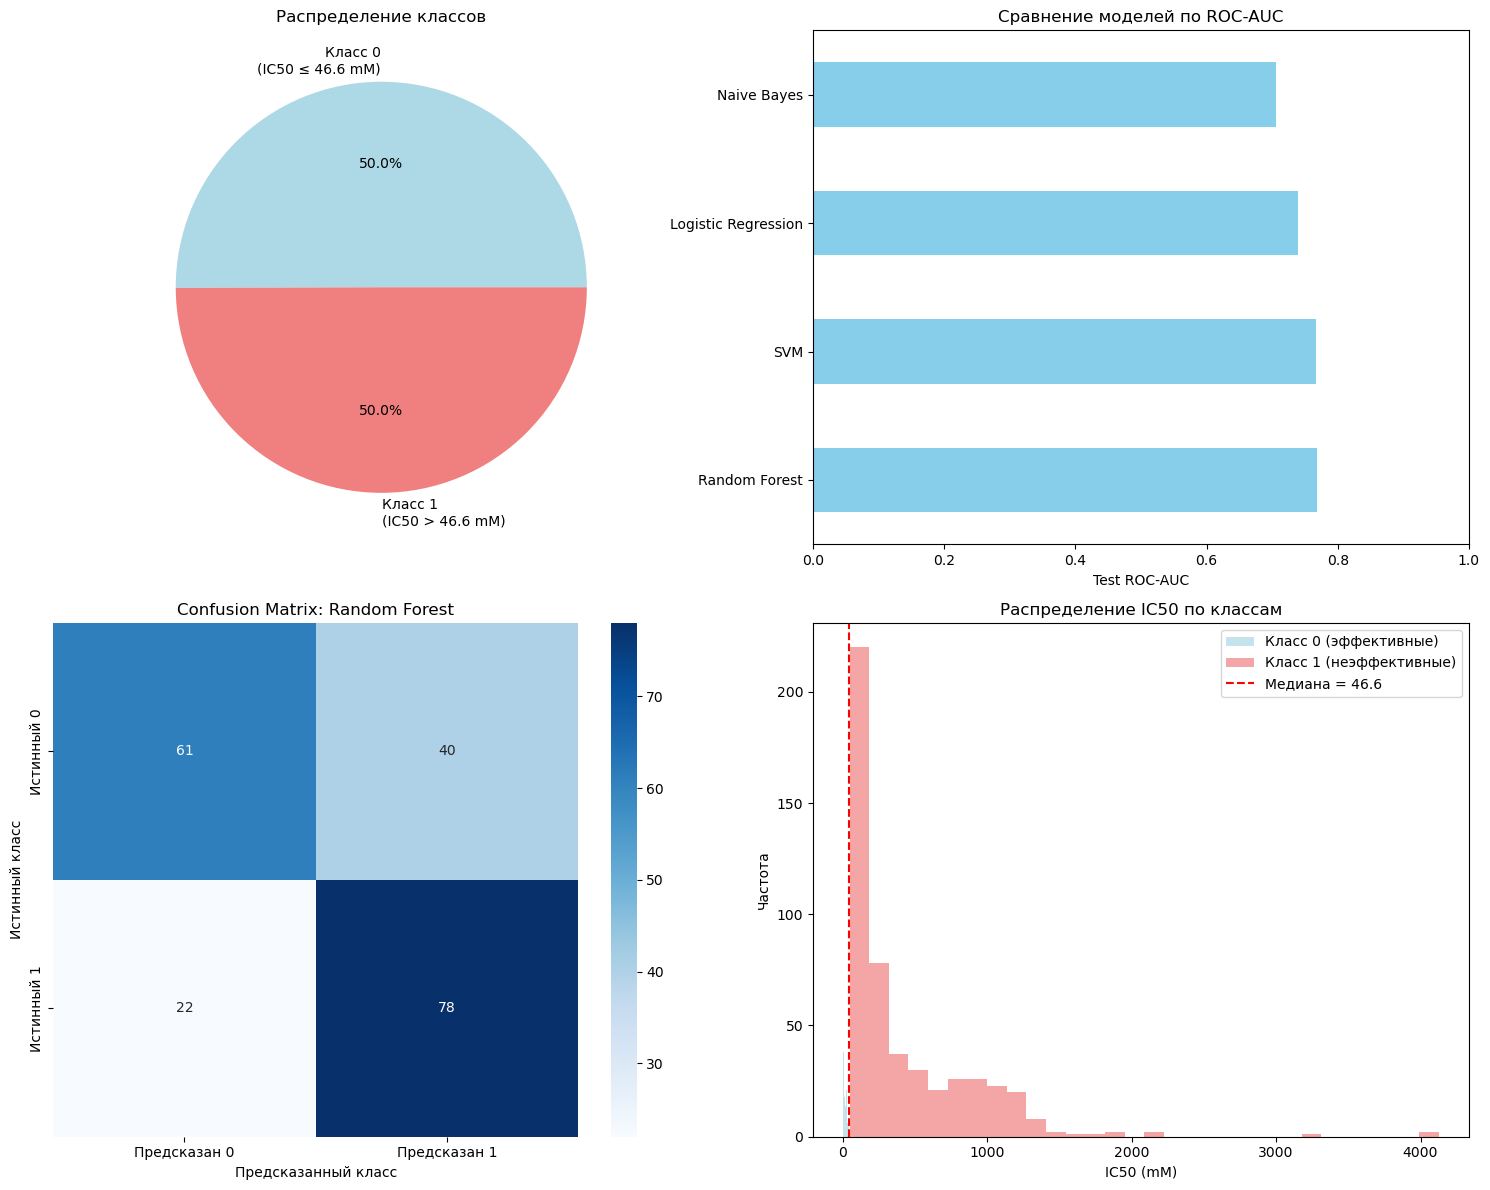

                                precision    recall  f1-score   support

  Эффективные (IC50 ≤ медианы)      0.735     0.604     0.663       101
Неэффективные (IC50 > медианы)      0.661     0.780     0.716       100

                      accuracy                          0.692       201
                     macro avg      0.698     0.692     0.689       201
                  weighted avg      0.698     0.692     0.689       201



In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

class_counts = pd.Series(y).value_counts().sort_index()
class_labels = [f'Класс 0\n(IC50 ≤ {ic50_median:.1f} mM)', f'Класс 1\n(IC50 > {ic50_median:.1f} mM)']
axes[0,0].pie(class_counts.values, labels=class_labels, autopct='%1.1f%%', 
              colors=['lightblue', 'lightcoral'])
axes[0,0].set_title('Распределение классов')

results_df['Test ROC-AUC'].plot(kind='barh', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Сравнение моделей по ROC-AUC')
axes[0,1].set_xlabel('Test ROC-AUC')
axes[0,1].set_xlim(0, 1)

y_test = best_result['y_test']
y_pred = best_result['y_pred']

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
            xticklabels=['Предсказан 0', 'Предсказан 1'],
            yticklabels=['Истинный 0', 'Истинный 1'])
axes[1,0].set_title(f'Confusion Matrix: {best_model_name}')
axes[1,0].set_xlabel('Предсказанный класс')
axes[1,0].set_ylabel('Истинный класс')

ic50_class0 = ic50_values[y == 0]
ic50_class1 = ic50_values[y == 1]

axes[1,1].hist(ic50_class0, bins=30, alpha=0.7, label='Класс 0 (эффективные)', color='lightblue')
axes[1,1].hist(ic50_class1, bins=30, alpha=0.7, label='Класс 1 (неэффективные)', color='lightcoral')
axes[1,1].axvline(ic50_median, color='red', linestyle='--', label=f'Медиана = {ic50_median:.1f}')
axes[1,1].set_xlabel('IC50 (mM)')
axes[1,1].set_ylabel('Частота')
axes[1,1].set_title('Распределение IC50 по классам')
axes[1,1].legend()

plt.tight_layout()
plt.show()


target_names = ['Эффективные (IC50 ≤ медианы)', 'Неэффективные (IC50 > медианы)']
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

Лучшая модель (Random Forest) показывает ROC-AUC = 0.768

Точность классификации: 69.2%